In [2]:
#import libraries
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pandas as pd
import sklearn
from shapely import wkt

In [9]:
#retrieve cleaned data frames 
data_dir = '/Users/jyontika/Desktop/opioid-overdose-models/cook-county/cleaning-cook-county/'
gdf_annual = pd.read_csv(f'{data_dir}/cook_county_gdf_year.csv')
gdf_quarter = pd.read_csv(f'{data_dir}/cook_county_gdf_quarterly.csv')
gdf_semi = pd.read_csv(f'{data_dir}/cook_county_gdf_semiannual.csv')

#convert to gpd (was having trouble importing csv as gdf)
gdf_annual['geometry'] = gdf_annual['geometry'].apply(wkt.loads)
gdf_annual = gpd.GeoDataFrame(gdf_annual, geometry='geometry')
gdf_annual.crs = {'init': 'EPSG:4269'}
type(gdf_annual)

gdf_quarter['geometry'] = gdf_quarter['geometry'].apply(wkt.loads)
gdf_quarter = gpd.GeoDataFrame(gdf_quarter, geometry='geometry')
gdf_quarter.crs = {'init': 'EPSG:4269'}
type(gdf_quarter)

gdf_semi['geometry'] = gdf_semi['geometry'].apply(wkt.loads)
gdf_semi = gpd.GeoDataFrame(gdf_semi, geometry='geometry')
gdf_semi.crs = {'init': 'EPSG:4269'}
type(gdf_semi)

/Users/jyontika/Library/Python/3.9/lib/python/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/jyontika/Library/Python/3.9/lib/python/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/jyontika/Library/Python/3.9/lib/python/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred i

geopandas.geodataframe.GeoDataFrame

### Sparsity Rate Tables

In [26]:
#annual
sparsity_df_annual = pd.DataFrame(columns=['year', 'Total Deaths', 'Sparsity Rate'])

years = range(2015, 2023)
for year in years:
    year_df = gdf_annual[gdf_annual['year'] == year]
    zero_deaths_count = year_df[year_df['deaths'] == 0].shape[0]
    total_count = year_df.shape[0]
    sparsity_rate = (zero_deaths_count / total_count) * 100
    total_deaths = year_df['deaths'].sum()
    sparsity_df_annual = pd.concat([sparsity_df_annual, pd.DataFrame({'year': [year], 'Total Deaths': [total_deaths], 'Sparsity Rate': [sparsity_rate]})], ignore_index=True)


raw_sparsity = sparsity_df_annual['Sparsity Rate']
sparsity_df_annual['Sparsity Rate'] = sparsity_df_annual['Sparsity Rate'].round(3).astype(str) + '%'
print(sparsity_df_annual)

   year Total Deaths Sparsity Rate
0  2015          616       67.244%
1  2016         1026       53.765%
2  2017         1109       53.163%
3  2018         1075       54.443%
4  2019         1209       52.033%
5  2020         1685       43.524%
6  2021         1790       43.072%
7  2022         1847       42.997%


In [27]:
##quarterly sparsity table

quarterly_deaths = gdf_quarter.groupby(['year', 'quarter'])['deaths'].sum().reset_index()

# Calculate sparsity rate
zero_deaths_count = gdf_quarter[gdf_quarter['deaths'] == 0].groupby(['year', 'quarter']).size().reset_index(name='Zero Deaths Count')
total_tracts_count = gdf_quarter.groupby(['year', 'quarter']).size().reset_index(name='Total Tracts Count')
sparsity_df_quarter = pd.merge(zero_deaths_count, total_tracts_count, on=['year', 'quarter'])
sparsity_df_quarter['Sparsity Rate'] = (sparsity_df_quarter['Zero Deaths Count'] / sparsity_df_quarter['Total Tracts Count']) * 100
sparsity_df_quarter['Sparsity Rate'] = sparsity_df_quarter['Sparsity Rate'].round(3).astype(str) + '%'

# Merge sparsity rate with quarterly_deaths table
quarterly_deaths = pd.merge(quarterly_deaths, sparsity_df_quarter[['year', 'quarter', 'Sparsity Rate']], on=['year', 'quarter'])

# Rename the 'deaths' column
quarterly_deaths.rename(columns={'deaths': 'Total Deaths'}, inplace=True)

# Exclude 2023 from the table
quarterly_deaths = quarterly_deaths[quarterly_deaths['year'] != 2023]

# Add an extra space between every year (or after every 4 quarters)
formatted_table = ''
current_year = None
for _, row in quarterly_deaths.iterrows():
    year = row['year']
    quarter = row['quarter']
    total_deaths = row['Total Deaths']
    sparsity_rate = row['Sparsity Rate']
    
    if year != current_year:
        formatted_table += '\n'  # Add an extra space between years
        current_year = year
    
    formatted_table += f"Year: {year}, Quarter: {quarter}, Total Deaths: {total_deaths}, Sparsity Rate: {sparsity_rate}\n"

# Print the resulting table
print(formatted_table)



Year: 2015, Quarter: 1, Total Deaths: 131, Sparsity Rate: 90.587%
Year: 2015, Quarter: 2, Total Deaths: 147, Sparsity Rate: 89.533%
Year: 2015, Quarter: 3, Total Deaths: 158, Sparsity Rate: 89.458%
Year: 2015, Quarter: 4, Total Deaths: 180, Sparsity Rate: 87.877%

Year: 2016, Quarter: 1, Total Deaths: 233, Sparsity Rate: 84.639%
Year: 2016, Quarter: 2, Total Deaths: 299, Sparsity Rate: 81.25%
Year: 2016, Quarter: 3, Total Deaths: 218, Sparsity Rate: 86.145%
Year: 2016, Quarter: 4, Total Deaths: 276, Sparsity Rate: 82.831%

Year: 2017, Quarter: 1, Total Deaths: 289, Sparsity Rate: 82.605%
Year: 2017, Quarter: 2, Total Deaths: 221, Sparsity Rate: 85.768%
Year: 2017, Quarter: 3, Total Deaths: 286, Sparsity Rate: 82.53%
Year: 2017, Quarter: 4, Total Deaths: 313, Sparsity Rate: 80.873%

Year: 2018, Quarter: 1, Total Deaths: 271, Sparsity Rate: 83.961%
Year: 2018, Quarter: 2, Total Deaths: 246, Sparsity Rate: 84.488%
Year: 2018, Quarter: 3, Total Deaths: 271, Sparsity Rate: 82.53%
Year: 201

In [16]:
#semi-annual
semiannual_deaths = gdf_semi.groupby(['year', 'semiannual'])['deaths'].sum().reset_index()

# Calculate sparsity rate
zero_deaths_count = gdf_semi[gdf_semi['deaths'] == 0].groupby(['year', 'semiannual']).size().reset_index(name='Zero Deaths Count')
total_tracts_count = gdf_semi.groupby(['year', 'semiannual']).size().reset_index(name='Total Tracts Count')
sparsity_df_semi = pd.merge(zero_deaths_count, total_tracts_count, on=['year', 'semiannual'])
sparsity_df_semi['Sparsity Rate'] = (sparsity_df_semi['Zero Deaths Count'] / sparsity_df_semi['Total Tracts Count']) * 100
sparsity_df_semi['Sparsity Rate'] = sparsity_df_semi['Sparsity Rate'].round(3).astype(str) + '%'

# Merge sparsity rate with semiannual_deaths table
semiannual_deaths = pd.merge(semiannual_deaths, sparsity_df_semi[['year', 'semiannual', 'Sparsity Rate']], on=['year', 'semiannual'])

semiannual_deaths.rename(columns={'deaths': 'Total Deaths'}, inplace=True)

#format
formatted_table = ''
current_year = None
for _, row in semiannual_deaths.iterrows():
    year = row['year']
    semiannual = row['semiannual']
    total_deaths = row['Total Deaths']
    sparsity_rate = row['Sparsity Rate']
    
    if year != current_year:
        formatted_table += '\n'  # Add an extra space between years
        current_year = year
    
    formatted_table += f"Year: {year}, Semiannual: {semiannual}, Total Deaths: {total_deaths}, Sparsity Rate: {sparsity_rate}\n"

# Print the resulting table
#print(formatted_table)




### Number Tracts with 5+ Deaths

In [29]:
#number of census tracts with 5+ deaths in a year
filtered_df = gdf_annual[(gdf_annual['year'] >= 2015 ) & (gdf_annual['year'] <= 2022)]

result = filtered_df.groupby('year').apply(lambda x: (x['deaths'] >= 5).sum()).reset_index()

result.columns = ['Year', '   # of Tracts']
print("Number of Census Tracts with\n  5+ Deaths in Given Year\n")
print(result)


Number of Census Tracts with
  5+ Deaths in Given Year

   Year     # of Tracts
0  2015               6
1  2016              25
2  2017              29
3  2018              30
4  2019              33
5  2020              69
6  2021              76
7  2022              96


In [30]:
result = gdf_semi.groupby(['year', 'semiannual']).apply(lambda x: (x['deaths'] >= 5).sum()).reset_index()
result.columns = ['Year', 'Semiannual Period', '# of Tracts']
print("Number of Census Tracts with 5+ Deaths in Given Semiannual Period\n")
print(result)

Number of Census Tracts with 5+ Deaths in Given Semiannual Period

    Year  Semiannual Period  # of Tracts
0   2015                  1            0
1   2015                  2            0
2   2016                  1            4
3   2016                  2            3
4   2017                  1            6
5   2017                  2            7
6   2018                  1            6
7   2018                  2            7
8   2019                  1            6
9   2019                  2           10
10  2020                  1           20
11  2020                  2           12
12  2021                  1           19
13  2021                  2           28
14  2022                  1           19
15  2022                  2           28


### Summary Stats Semi-Annual

In [31]:
#summary stats semi-annual
#mean and median
gdf_semi_filtered = gdf_semi[gdf_semi['year'].between(2015, 2021)]
mean_deaths = gdf_semi_filtered['deaths'].mean()
median_deaths = gdf_semi_filtered['deaths'].median()

print(mean_deaths)
print(median_deaths)

0.457723752151463
0.0


In [32]:
# percentiles semiannual
percentile_25 = np.percentile(gdf_semi_filtered['deaths'], 25)
percentile_75 = np.percentile(gdf_semi_filtered['deaths'], 75)

print("25th Percentile:", percentile_25)
print("75th Percentile:", percentile_75)

25th Percentile: 0.0
75th Percentile: 1.0


In [33]:
#maximum and min semi-annual
max_deaths = gdf_semi_filtered['deaths'].max()
min_deaths = gdf_semi_filtered['deaths'].min()

print("Maximum Number of Deaths:", max_deaths)
print("Minimum Number of Deaths:", min_deaths)

Maximum Number of Deaths: 17
Minimum Number of Deaths: 0


### Annual Summary Statistics

In [34]:
#calculate mean from 2015-2021?
#annual

filtered_df = gdf_annual[(gdf_annual['year'] >= 2015) & (gdf_annual['year'] <= 2021)]
mean_deaths = filtered_df['deaths'].mean()
median_deaths = filtered_df['deaths'].median()

print(mean_deaths)
print(median_deaths)


0.915447504302926
0.0


In [35]:
# percentiles ANNUAL
percentile_25 = np.percentile(filtered_df['deaths'], 25)
percentile_75 = np.percentile(filtered_df['deaths'], 75)

print("25th Percentile:", percentile_25)
print("75th Percentile:", percentile_75)

25th Percentile: 0.0
75th Percentile: 1.0


In [36]:
#min and max ANNUAL
max_deaths = filtered_df['deaths'].max()
min_deaths = filtered_df['deaths'].min()

print("Maximum Number of Deaths:", max_deaths)
print("Minimum Number of Deaths:", min_deaths)

Maximum Number of Deaths: 24
Minimum Number of Deaths: 0


### Summary Stats Quarterly

In [37]:
#summary stats QUARTERLY
#mean and median
gdf_quarter_filtered = gdf_quarter[gdf_quarter['year'].between(2015, 2021)]
mean_deaths = gdf_quarter_filtered['deaths'].mean()
median_deaths = gdf_quarter_filtered['deaths'].median()

print(mean_deaths)
print(median_deaths)

0.2288618760757315
0.0


In [38]:
# percentiles quarterly
percentile_25 = np.percentile(gdf_quarter_filtered['deaths'], 25)
percentile_75 = np.percentile(gdf_quarter_filtered['deaths'], 75)

print("25th Percentile:", percentile_25)
print("75th Percentile:", percentile_75)

25th Percentile: 0.0
75th Percentile: 0.0


In [39]:
#maximum and min quarterly
max_deaths = gdf_quarter_filtered['deaths'].max()
min_deaths = gdf_quarter_filtered['deaths'].min()

print("Maximum Number of Deaths:", max_deaths)
print("Minimum Number of Deaths:", min_deaths)

Maximum Number of Deaths: 11
Minimum Number of Deaths: 0


### Plots

<Axes: >

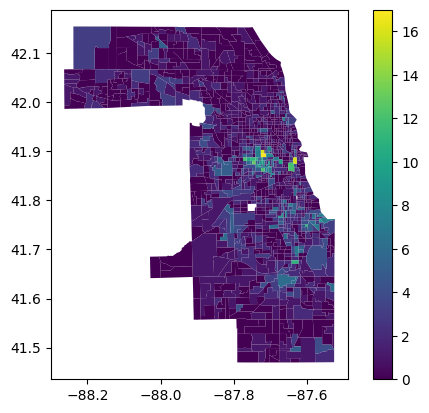

In [7]:
gdf_annual[gdf_annual['year']==2022].plot('deaths', legend=True)


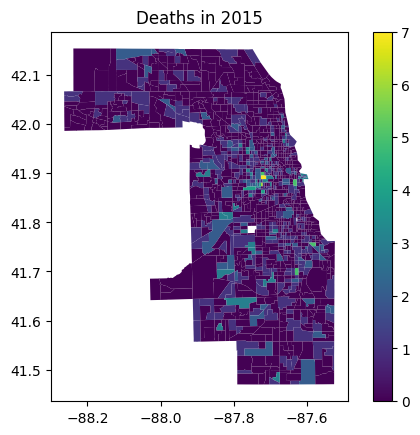

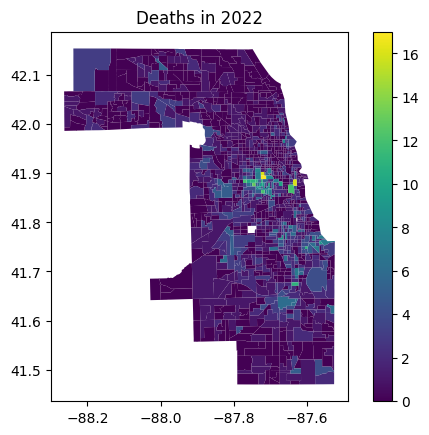

In [23]:
def plot_deaths(df, year, average_deaths):
    df_filtered = df[df['year'] == year]
    ax = df_filtered.plot(column='deaths', legend=True)
    return ax

ax1 = plot_deaths(gdf_annual, 2015)
ax2 = plot_deaths(gdf_annual, 2022)

ax1.set_title("Deaths in 2015")
ax2.set_title("Deaths in 2022")

plt.show()


<Axes: >

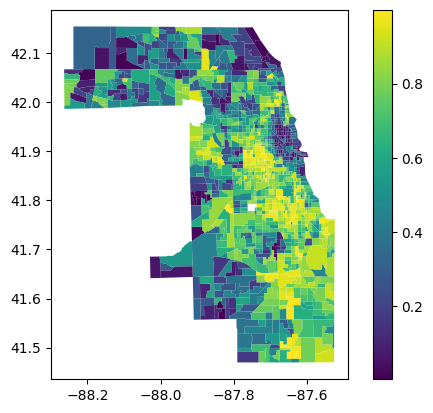

In [42]:
gdf_annual[gdf_annual['year']==2022].plot('svi_pctile', legend=True)
